In [1]:
import math
import pandas as pd
import json
import urllib
import requests
from bs4 import BeautifulSoup #for web scrapping
import re
from datetime import datetime
import matplotlib.pyplot as plt
# for getting weather report of a particular location
from meteostat import Point, Daily,Hourly

In [5]:
requests.__version__

'2.24.0'

In [205]:
wikiurl="https://en.wikipedia.org/wiki/List_of_municipalities_in_Alberta"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [212]:
soup = BeautifulSoup(response.text, 'html.parser')
indiatable = soup.find_all("table", attrs={"class": "wikitable"})
# indiatable=soup.find('table',{'class':"wikitable sortable"})

In [213]:
#Number of table in the site
print("Number of tables on site: ",len(indiatable))

Number of tables on site:  4


In [239]:
table1 = indiatable[0]
# the head will form our column names
body = table1.find_all("tr")
# Head values (Column names) are the first items of the body list
head = body[0] # 0th item is the header row
body_rows = body[1:] # All other items becomes the rest of the rows

# Lets now iterate through the head HTML code and make list of clean headings

# Declare empty list to keep Columns names
headings = []
for item in head.find_all("th"): # loop through all th elements
    # convert the th elements to text and strip "\n"
    item = (item.text).rstrip("\n")
    # append the clean column name to headings
    headings.append(item)
print(headings)

['Name', 'Status[2]', 'Incorporation date(current status)[15][17][18][22]', '2016 Census of Population[3]']


In [223]:
upd = ['population 2011','change','Land Area','population density']

In [243]:
headings.extend(upd)

In [244]:
headings

['Name',
 'Status[2]',
 'Incorporation date(current status)[15][17][18][22]',
 '2016 Census of Population[3]',
 'population 2011',
 'change',
 'Land Area',
 'population density']

In [240]:
all_rows = [] # will be a list for list for all rows
for row_num in range(len(body_rows)): # A row at a time
    row = [] # this will old entries for one row
    for row_item in body_rows[row_num].find_all("td"): #loop through all row entries
        # row_item.text removes the tags from the entries
        # the following regex is to remove \xa0 and \n and comma from row_item.text
        # xa0 encodes the flag, \n is the newline and comma separates thousands in numbers
        aa = re.sub("(\xa0)|(\n)|,","",row_item.text)
        #append aa to row - note one row entry is being appended
        row.append(aa)
    # append one row to all_rows
    all_rows.append(row)

In [245]:
alberta_city = pd.DataFrame(data=all_rows,columns=headings)
alberta_city.head()

,Name,Status[2],Incorporation date(current status)[15][17][18][22],2016 Census of Population[3],population 2011,change,Land Area,population density
0,None,None,None,None,None,None,None,None
1,Acme,Village,July 7 1910,653,653,0.0%,2.48,263.3/km2
2,Airdrie,City,January 1 1985,61581,43271,+42.3%,84.57,728.2/km2
3,Alberta Beach,Village,January 1 1999,1018,865,+17.7%,2.01,506.5/km2
4,Alix,Village,June 3 1907,734,830,−11.6%,3.13,234.5/km2


In [231]:
# drop row with total values
alberta_city = alberta_city.drop(index=[0,75,76,77,78,79],axis=0)

In [248]:
drop_title=[
 'Incorporation date(current status)[15][17][18][22]',
 'population 2011',
 'change',
 'Land Area',
 'population density']

In [249]:
alberta_city =alberta_city.drop(columns=drop_title)

In [250]:
alberta_city.to_csv('alberta_city.csv')

In [307]:
df_alberta_city = pd.read_csv('alberta_citynew.csv',index_col='Unnamed: 0')

In [ ]:
URL = "https://geocode.search.hereapi.com/v1/geocode"  # Deevloper Here API link
api_key = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [266]:
def getCoordinates(location):
    PARAMS = {'apikey': api_key, 'q': location} # required parameters
    r = requests.get(url=URL, params=PARAMS)  # pass in required parameters
    # get raw json file. I did  this because when I combined this step with my "getLocation" function, 
    # it gave me error for countries with no country_code or country_name. Hence, I needed to use try - except block
    data = r.json() # Raw json file 
    return data

In [298]:
def getLocation(location):
    location = getCoordinates(location)
    for data in location:
        if len(location['items'])>0:
            latitude = location['items'][0]['position']['lat']
            longitude = location['items'][0]['position']['lng']
            try:   
                country_code = location['items'][0]['address']['countryCode']
                country_name = location['items'][0]['address']['countryName']
                city = location['items'][0]['address']['label']

            except KeyError:
                country_code = float('Nan')
                country_name = float('Nan')
        else: 
            latitude = float('Nan')
            longitude = float('Nan')
            country_code = float('Nan') 
            country_name = float('Nan')
        result = (latitude, longitude)
    return result

In [308]:
df_alberta_city.head()

,Name,Status,Country,Province,2016 Census of Population
1,Acme,Village,Canada,Alberta,653
2,Airdrie,City,Canada,Alberta,61581
3,Alberta Beach,Village,Canada,Alberta,1018
4,Alix,Village,Canada,Alberta,734
5,Alliance,Village,Canada,Alberta,154


In [300]:
rst = getLocation('grande prairie Alberta')

In [313]:
df_alberta_city['Lat&Long'] = df_alberta_city.apply(lambda x: getLocation(x['Name']+' '+x['Province']), axis=1)

In [315]:
df_alberta_city.to_csv('alberta_citylatlon.csv')

In [316]:
df_alberta_city.isna().sum()

Name                         0
Status                       0
Country                      0
Province                     0
2016 Census of Population    0
Lat&Long                     0
dtype: int64

In [518]:
# Set time period
start = datetime(2021, 2, 7)
end = datetime(2021, 2, 15)
va = Point(51.04532, -114.06301)
data11 = Daily(va, start, end)

In [520]:
fetch_df = data11.fetch()
fetch_df

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2021-02-07,-27.2,-31.1,-23.0,NaN,NaN,148.9,10.1,NaN,NaN,NaN
2021-02-08,-26.4,-31.1,-23.5,NaN,NaN,NaN,13.7,NaN,NaN,NaN
2021-02-09,-28.4,-31.1,-25.5,NaN,NaN,277.6,10.2,NaN,NaN,NaN
2021-02-10,-28.3,-31.1,-26.0,NaN,NaN,173.2,12.8,NaN,NaN,NaN
2021-02-11,-30.0,-33.7,-25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-12,-21.0,-28.7,-17.5,NaN,NaN,250.4,13.6,NaN,NaN,NaN
2021-02-13,-20.8,-23.0,-18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [407]:
def temp_rang(x):
    start = datetime(2021, 2, 7)
    end = datetime(2021, 2, 15)
    city = Point(x[0], x[1])
    try:
        data = Daily(city, start, end)
        data= data.fetch()
        return [data.tmax.to_list(),data.tmin.to_list(),data.tavg.to_list()]
    except IndexError:
        data=np.NaN
        return data

In [334]:
df_alberta_city.head()

,Name,Status,Country,Province,2016 Census of Population,Lat&Long
1,Acme,Village,Canada,Alberta,653,"(51.49533, -113.50819)"
2,Airdrie,City,Canada,Alberta,61581,"(51.2887, -114.01344)"
3,Alberta Beach,Village,Canada,Alberta,1018,"(53.67186, -114.36056)"
4,Alix,Village,Canada,Alberta,734,"(52.4004, -113.18862)"
5,Alliance,Village,Canada,Alberta,154,"(52.43554, -111.78503)"


In [410]:
df_alberta_city['tmax_tmin_tavg']=df_alberta_city['Lat&Long'].apply(lambda x:temp_rang(x))

In [414]:
df_alberta_city

,Name,Status,Country,Province,2016 Census of Population,Lat&Long,tmax_tmin_tavg
1,Acme,Village,Canada,Alberta,653,"(51.49533, -113.50819)","[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [..."
2,Airdrie,City,Canada,Alberta,61581,"(51.2887, -114.01344)","[[-23.0, -23.5, -25.5, -26.0, -25.5, -17.5, -1..."
3,Alberta Beach,Village,Canada,Alberta,1018,"(53.67186, -114.36056)","[[-26.0, -25.0, -25.0, -25.0, -23.0, -19.0, -1..."
4,Alix,Village,Canada,Alberta,734,"(52.4004, -113.18862)","[[-24.0, -27.0, -26.0, -28.0, -25.0, -20.0], [..."
5,Alliance,Village,Canada,Alberta,154,"(52.43554, -111.78503)",NaN
...,...,...,...,...,...,...,...
259,Whispering Hills,Summer village,Canada,Alberta,142,"(54.75517, -113.53386)","[[], [], []]"
260,White Sands,Summer village,Canada,Alberta,120,"(52.46759, -112.8137)","[[-25.0, -27.0, -26.0, -28.0, -24.0, -20.0], [..."
261,Whitecourt,Town,Canada,Alberta,10204,"(54.12541, -115.66208)",NaN
262,Yellowstone,Summer village,Canada,Alberta,137,"(53.73544, -114.37909)",NaN


In [446]:
df_alberta_city = df_alberta_city.dropna().reset_index(drop=True)

In [451]:
# drop row where temperature report is empty
drop_nos = df_alberta_city[df_alberta_city['tmax_tmin_tavg'].str[0].str.len()==0].index.to_list()

In [547]:
df_alberta_city[df_alberta_city['tmax_tmin_tavg'].str[0].str.len()>6].count()

Name                         0
Status                       0
Country                      0
Province                     0
2016 Census of Population    0
Lat&Long                     0
tmax_tmin_tavg               0
Tmax                         0
Tmin                         0
Tavg                         0
Timeline                     0
dtype: int64

In [453]:
df_alberta_city=df_alberta_city.drop(index=drop_nos).reset_index(drop=True)

In [541]:
# remove row if report is more than 6 day
drop_nos2 = df_alberta_city[df_alberta_city['tmax_tmin_tavg'].str[0].str.len()>6].index.to_list()

In [546]:
df_alberta_city = df_alberta_city.drop(index=drop_nos2).reset_index(drop=True)

In [454]:
df_alberta_city.head(15)

,Name,Status,Country,Province,2016 Census of Population,Lat&Long,tmax_tmin_tavg
0,Acme,Village,Canada,Alberta,653,"(51.49533, -113.50819)","[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [..."
1,Airdrie,City,Canada,Alberta,61581,"(51.2887, -114.01344)","[[-23.0, -23.5, -25.5, -26.0, -25.5, -17.5, -1..."
2,Alberta Beach,Village,Canada,Alberta,1018,"(53.67186, -114.36056)","[[-26.0, -25.0, -25.0, -25.0, -23.0, -19.0, -1..."
3,Alix,Village,Canada,Alberta,734,"(52.4004, -113.18862)","[[-24.0, -27.0, -26.0, -28.0, -25.0, -20.0], [..."
4,Andrew,Village,Canada,Alberta,425,"(53.87915, -112.33186)","[[-26.0, -26.5, -27.0, -26.5, -23.0, -20.5], [..."
5,Arrowwood,Village,Canada,Alberta,207,"(50.73719, -113.15045)","[[-26.0, -25.0, -26.0, -28.0, -27.0, -19.0], [..."
6,Barnwell,Village,Canada,Alberta,947,"(49.76051, -112.26247)","[[-23.0, -23.0, -24.7, -25.4, -26.0, -19.4], [..."
7,Barons,Village,Canada,Alberta,341,"(50.00002, -113.08764)","[[-23.0, -22.0, -24.0, -25.0, -26.0, -19.0], [..."
8,Bassano,Town,Canada,Alberta,1206,"(50.78587, -112.46641)","[[-25.0, -26.0, -25.0, -26.0, -26.0, -20.0], [..."
9,Beaumont,City,Canada,Alberta,17396,"(53.35783, -113.41366)","[[-26.1, -25.4, -25.7, -25.7, -23.3, -19.0, -2..."


In [458]:
df_alberta_city[['Tmax','Tmin','Tavg']]= pd.DataFrame(df_alberta_city['tmax_tmin_tavg'].tolist(), index= df_alberta_city.index)

In [506]:
# I used this to convert my object list in column Timeline to a list
# in order to enable explode work properly 
from ast import literal_eval

'Airdrie'

In [526]:
# pivot and merge
a="['2021-02-07','2021-02-08','2021-02-09','2021-02-10','2021-02-11','2021-02-12']"
df_alberta_city['Timeline'] = a
# "[2021-02-07,2021-02-08,2021-02-09,2021-02-10,2021-02-11,2021-02-12,2021-02-13]"

In [527]:
df_alberta_city['Timeline'] = df_alberta_city['Timeline'].apply(literal_eval) #convert to list type

In [534]:
df_alberta_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Name                       169 non-null    object
 1   Status                     169 non-null    object
 2   Country                    169 non-null    object
 3   Province                   169 non-null    object
 4   2016 Census of Population  169 non-null    int64 
 5   Lat&Long                   169 non-null    object
 6   tmax_tmin_tavg             169 non-null    object
 7   Tmax                       169 non-null    object
 8   Tmin                       169 non-null    object
 9   Tavg                       169 non-null    object
 10  Timeline                   169 non-null    object
dtypes: int64(1), object(10)
memory usage: 14.6+ KB


In [550]:
list_cols = {'Tmax','Tmin','Tavg','Timeline'}
other_cols = list(set(df_alberta_city.columns) - set(list_cols))
exploded = [df_alberta_city[col].explode() for col in list_cols]
sample_df = pd.DataFrame(dict(zip(list_cols, exploded)))
sample_df = df_alberta_city[other_cols].merge(sample_df, how="right", left_index=True, right_index=True)

In [553]:
sample_df.head()

,Status,Country,2016 Census of Population,Name,tmax_tmin_tavg,Lat&Long,Province,Timeline,Tavg,Tmin,Tmax
0,Village,Canada,653,Acme,"[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [...","(51.49533, -113.50819)",Alberta,2021-02-07,-35.8,-41,-29
0,Village,Canada,653,Acme,"[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [...","(51.49533, -113.50819)",Alberta,2021-02-08,-32.9,-40,-26
0,Village,Canada,653,Acme,"[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [...","(51.49533, -113.50819)",Alberta,2021-02-09,-30.9,-35,-26
0,Village,Canada,653,Acme,"[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [...","(51.49533, -113.50819)",Alberta,2021-02-10,-30.7,-35,-27
0,Village,Canada,653,Acme,"[[-29.0, -26.0, -26.0, -27.0, -24.0, -19.0], [...","(51.49533, -113.50819)",Alberta,2021-02-11,-30,-35,-24


In [552]:
sample_df.columns

Index(['Status', 'Country', '2016 Census of Population', 'Name',
       'tmax_tmin_tavg', 'Lat&Long', 'Province', 'Timeline', 'Tavg', 'Tmin',
       'Tmax'],
      dtype='object')

In [558]:
sample_df[to_use].to_csv('Full_table.csv',index= False)

In [4]:
sample_df =pd.read_csv('Full_table.csv')

In [560]:
pd.read_csv('Full_table.csv').head(25)

,Timeline,Name,Status,Country,2016 Census of Population,Lat&Long,Province,Tavg,Tmin,Tmax
0,2021-02-07,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-35.8,-41.0,-29.0
1,2021-02-08,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-32.9,-40.0,-26.0
2,2021-02-09,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-30.9,-35.0,-26.0
3,2021-02-10,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-30.7,-35.0,-27.0
4,2021-02-11,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-30.0,-35.0,-24.0
5,2021-02-12,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-21.2,-23.0,-19.0
6,2021-02-07,Alix,Village,Canada,734,"(52.4004, -113.18862)",Alberta,-28.9,-35.0,-24.0
7,2021-02-08,Alix,Village,Canada,734,"(52.4004, -113.18862)",Alberta,-30.0,-33.0,-27.0
8,2021-02-09,Alix,Village,Canada,734,"(52.4004, -113.18862)",Alberta,-30.3,-34.0,-26.0
9,2021-02-10,Alix,Village,Canada,734,"(52.4004, -113.18862)",Alberta,-30.5,-32.0,-28.0


In [6]:
sample_df.head()

,Timeline,Name,Status,Country,2016 Census of Population,Lat&Long,Province,Tavg,Tmin,Tmax
0,2021-02-07,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-35.8,-41.0,-29.0
1,2021-02-08,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-32.9,-40.0,-26.0
2,2021-02-09,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-30.9,-35.0,-26.0
3,2021-02-10,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-30.7,-35.0,-27.0
4,2021-02-11,Acme,Village,Canada,653,"(51.49533, -113.50819)",Alberta,-30.0,-35.0,-24.0


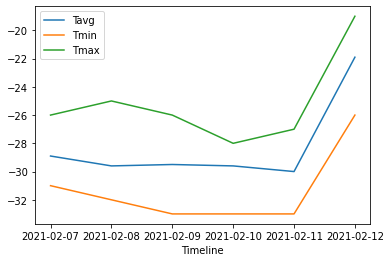

In [11]:
sample_df[sample_df.Name=='Strathmore'].plot(x='Timeline',y=['Tavg', 'Tmin', 'Tmax'])
plt.show()